In [ ]:
"""
PROEBLEMs:

a problem with the shuffling of the data: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
give weights to classes: #https://www.tensorflow.org/tutorials/structured_data/imbalanced_data --> it'll depend on the magnitude of the loss functions
validation rn --> change loading images train, we've done it before
dealing with class imbalance --> file:///C:/Users/pablo/Downloads/Survey_on_deep_learning_with_class_imbalance.pdf

TODOs:

test my model with oxford --> https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet /// https://www.kaggle.com/spidy20/image-segmentation-using-unet-tensorflow
check the activation of layers --> https://awjuliani.medium.com/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4

"""

In [1]:
import os
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

#Run from server

gpu4 = "GPU-71b4cdfc-e381-0b98-9b24-4fc06284b496" 
gpu5 = "GPU-99d0769a-9f86-4800-a40e-2320dddcf5d1" 
gpu6 = "GPU-7423cfb5-cff4-ec4d-7e96-ea6e1591d56f"
gpu7 = "GPU-c0a8738f-6dd0-1b78-c38f-4969fd3886a8"

os.environ["CUDA_VISIBLE_DEVICES"]= gpu6 + "," + gpu5

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:XLA_GPU:1', '/device:GPU:0', '/device:GPU:1']


In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [26]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
IMG_DEPTH = 155
N_IMG = 369
length_file = IMG_DEPTH * N_IMG
h5py_file_name = 'training.hdf5'
smooth = 1

___

Generate and create data arrays

In [ ]:
ImgDir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData")
features_path = list()
labels_path = list()
count = 0
lim = 10

for folder in os.listdir(ImgDir):
    count +=1
    if 'Training' in folder:
        new_dir = os.path.join(ImgDir,folder)
        data = os.listdir(new_dir)
        for files in data:
            if 'flair' in files:
                features_path.append(os.path.join(new_dir, files))
            if 'seg' in files:
                labels_path.append(os.path.join(new_dir, files))

print(len(features_path))
print(len(labels_path))


In [ ]:
img_conc_features = np.zeros((len(features_path),IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))
path = features_path

for file, i in zip(path,range(len(path))):
    img = nib.load(file)
    imgarr = img.get_fdata()
    img_conc_features[i,:,:,:] = imgarr
    
img_conc_features = np.concatenate(img_conc_features,axis=2)
print(np.shape(img_conc_features))

In [ ]:
img_conc_labels = np.zeros((len(labels_path),IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))
path = labels_path

for file, i in zip(path,range(len(path))):
    img = nib.load(file)
    imgarr = img.get_fdata()
    img_conc_labels[i,:,:,:] = imgarr
    
img_conc_labels = np.concatenate(img_conc_labels,axis=2)
print(np.shape(img_conc_labels))

In [ ]:
with h5py.File(os.path.join('..','data',h5py_file_name), 'a') as f:
    f.create_dataset("features", data=img_conc_features, compression="gzip")
    f.create_dataset("labels", data=img_conc_labels, compression="gzip")

In [ ]:
hdf5_store_Brats = h5py.File(os.path.join('..','data',h5py_file_name), "r")
test_img = hdf5_store_Brats["features"][:, :, 100]
plt.imshow(test_img, cmap ='gray')
hdf5_store_Brats.close()

In [ ]:
hdf5_store_Brats = h5py.File(os.path.join('..','data',h5py_file_name), "r")
test_img = hdf5_store_Brats["labels"][:, :, 100]
plt.imshow(test_img, cmap ='gray')
hdf5_store_Brats.close()

___

Load data and model

In [5]:
# images = X_nib.get_fdata()
# labels = y_nib.get_fdata()

with h5py.File(os.path.join('..','data',h5py_file_name), "r") as f:
    images_train = f["features"][()]
    labels_train = f["labels"][()]

batch_size = 32

___

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [27]:
#https://towardsdatascience.com/using-custom-building-blocks-in-tensorflow-2-0-550b88eb7aa2

class My_Custom_Generator(tf.keras.utils.Sequence):
  
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = True
        
#     def on_epoch_end(self):
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)


    def __getitem__(self, idx) :
        batch_x = self.images[:,:,idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[:,:,idx * self.batch_size : (idx+1) * self.batch_size]
        #240,240,32
        batch_x /= 255.
        batch_y /= 255.

        train_image = np.zeros((batch_size,IMG_HEIGHT,IMG_WIDTH,3))
        train_label = np.zeros((batch_size,IMG_HEIGHT,IMG_WIDTH,3))
        
        #for i in range(0, len(batch_x)):
        for i in range(batch_size):

            X_new = np.zeros((240, 240 ,3), np.float32)
            y_new = np.zeros((240, 240 ,3), np.float32)

            X_new[:,:,0] = batch_x[:,:,i]
            X_new[:,:,1] = batch_x[:,:,i]
            X_new[:,:,2] = batch_x[:,:,i]

            y_new[:,:,0] = batch_y[:,:,i]
            y_new[:,:,1] = batch_y[:,:,i]
            y_new[:,:,2] = batch_y[:,:,i]

            train_image[i,:,:,:] = X_new
            train_label[i,:,:,:] = y_new

            #img_path = batch_x[i]
            #label = batch_y[i]
            #  # read method takes image path and label and returns corresponding matrices
            #image, label_matrix = read(img_path, label)
            #train_image.append(image)
            #train_label.append(label_matrix)
            
        #test channel creation done succesfully
        
        return np.array(train_image), np.array(train_label)

my_training_batch_generator = My_Custom_Generator(images_train, labels_train, batch_size)

In [7]:
class printbatch(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    #def on_epoch_end(self, epoch, logs=None):
    #    keys = list(logs.keys())
    #    
    #    print("End epoch {} of training; got log keys: {}".format(epoch, keys))

pb = printbatch()

In [28]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return (1-dice_coef(y_true, y_pred))

def get_model():
    in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])   

    #model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

    model.compile(optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000000199), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [29]:
model2=get_model()
model2.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 240, 240, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 240, 240, 16) 0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 240, 240, 16) 2320        dropout_14[0][0]                 
_______________________________________________________________________________________

In [20]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()

In [ ]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [30]:
# modify the fit_generator call to include the callback pb
training_history = model2.fit(x = my_training_batch_generator, steps_per_epoch = int(len(images_train) // batch_size), epochs = 20, verbose=1, callbacks=[pb], validation_data=None, class_weight=None)

Epoch 1/20
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_coef']
1/7 [===>..........................] - ETA: 0s - loss: 1.0000 - dice_coef: 3.6169e-07...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'dice_coef']
2/7 [=======>......................] - ETA: 1s - loss: 1.0000 - dice_coef: 3.6169e-07...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dice_coef']
3/7 [===========>..................] - ETA: 1s - loss: 1.0000 - dice_coef: 3.6169e-07...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'dice_coef']
4/7 [================>.............] - ETA: 1s - loss: 1.0000 - dice_coef: 3.6169e-07...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice_coef']
5/7 [====================>.........] - ETA: 1s - loss: 1.0000 - dice_coef: 3.6170e-0

6/7 [========================>.....] - ETA: 0s - loss: 1.0000 - dice_coef: 3.6198e-07...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['loss', 'dice_coef']
7/7 [==============================] - 4s 520ms/step - loss: 1.0000 - dice_coef: 3.6198e-07
Epoch 7/20
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_coef']
1/7 [===>..........................] - ETA: 0s - loss: 1.0000 - dice_coef: 3.6202e-07...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'dice_coef']
2/7 [=======>......................] - ETA: 1s - loss: 1.0000 - dice_coef: 3.6203e-07...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dice_coef']
3/7 [===========>..................] - ETA: 1s - loss: 1.0000 - dice_coef: 3.6203e-07...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'dice

5/7 [====================>.........] - ETA: 1s - loss: 1.0000 - dice_coef: 3.6242e-07...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['loss', 'dice_coef']
6/7 [========================>.....] - ETA: 0s - loss: 1.0000 - dice_coef: 3.6243e-07...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['loss', 'dice_coef']
7/7 [==============================] - 4s 551ms/step - loss: 1.0000 - dice_coef: 3.6243e-07
Epoch 13/20
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_coef']
1/7 [===>..........................] - ETA: 0s - loss: 1.0000 - dice_coef: 3.6248e-07...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'dice_coef']
2/7 [=======>......................] - ETA: 1s - loss: 1.0000 - dice_coef: 3.6249e-07...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dic

4/7 [================>.............] - ETA: 1s - loss: 1.0000 - dice_coef: 3.6291e-07...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice_coef']
5/7 [====================>.........] - ETA: 0s - loss: 1.0000 - dice_coef: 3.6292e-07...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['loss', 'dice_coef']
6/7 [========================>.....] - ETA: 0s - loss: 1.0000 - dice_coef: 3.6293e-07...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['loss', 'dice_coef']
7/7 [==============================] - 3s 479ms/step - loss: 1.0000 - dice_coef: 3.6293e-07
Epoch 19/20
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_coef']
1/7 [===>..........................] - ETA: 0s - loss: 1.0000 - dice_coef: 3.6298e-07...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'dic

KeyError: 'val_loss'

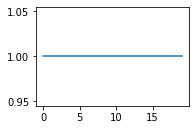

In [21]:
plot_metrics(training_history)

___

In [ ]:
import SimpleITK as sitk
img_flair = sitk.ReadImage(os.path.join("..", "data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_flair.nii.gz"))
nda_flair = sitk.GetArrayViewFromImage(img_flair)
print(np.shape(nda_flair))

for i in range(len(nda_flair[:,1,1])):

    X_new = np.zeros((240, 240 ,3), np.float32)

    X_new[:,:,0] = batch_x[:,:,i]
    X_new[:,:,1] = batch_x[:,:,i]
    X_new[:,:,2] = batch_x[:,:,i]

    train_image.append(X_new)

In [ ]:
def generator():
    
    data_length = len(X_nib.get_fdata()[1,1,:])
    chunks = np.floor(data_length / batch_size)
    print('A')
    X = X_nib.get_fdata()
    y = y_nib.get_fdata()
    print('B')
    X /= 255
    y /= 255
    print('C')
    
    while True:
        
        for i in range(int(chunks)):
            X_yield = []
            y_yield = []

            X_mod = X[:,:,i*32:(i+1)*32]
            y_mod = y[:,:,i*32:(i+1)*32]
            print(np.shape(X_mod))

            for j in range(32):
                X_new = np.zeros((240, 240 ,3), np.uint8)
                X_new[:,:,0] = X_mod[:,:,j]
                X_new[:,:,1] = X_mod[:,:,j]
                X_new[:,:,2] = X_mod[:,:,j]

                X_yield.append(X_new)
                print(np.shape(X_yield))

                y_new = np.zeros((240, 240 ,3), np.uint8)
                y_new[:,:,0] = y_mod[:,:,j]
                y_new[:,:,1] = y_mod[:,:,j]
                y_new[:,:,2] = y_mod[:,:,j]

                y_yield.append(y_new)

            yield np.reshape(X_yield,(32,240,240,3)), np.reshape(y_yield,(32,240,240,3))
        

my_generator = generator()